In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
from dateutil import tz
from math import sqrt

from sklearn.metrics import mean_squared_error, root_mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression

from scipy.stats import theilslopes, kendalltau, tstd

import ee
import geemap

pd.options.mode.copy_on_write = True

Инициализация GEE

In [2]:
geemap.ee_initialize()
oeel = geemap.requireJS()
ee.Authenticate()
ee.Initialize(project='ee-amazyar-test1')
baikal_shape = ee.FeatureCollection('projects/ee-amazyar-test/assets/baikal')

(node:17381) [DEP0040] DeprecationWarning: The `punycode` module is deprecated. Please use a userland alternative instead.
(Use `node --trace-deprecation ...` to show where the warning was created)


Приведение к читаемому виду

In [3]:
def add_timezone(df: pd.DataFrame) -> pd.DataFrame:
   # format = "%d.%m.%Y  %H:%M:%S"
   format = "%Y-%m-%d  %H:%M:%S"
   return df["Time"].apply(lambda dt: pd.to_datetime(dt, format=format).replace(tzinfo=tz.gettz("Asia/Irkutsk")))

In [4]:
df_lst = pd.read_csv('Наземеные_измерения/ready/Temp21-24_cut15.csv')
df_lst["Time"] = add_timezone(df_lst)
df_lst["T"] = df_lst['T'].astype(float)
df_lst["Lat"] = df_lst['Lat'].astype(float)
df_lst["Lon"] = df_lst['Lon'].astype(float)
df_lst

,Time,T,Lat,Lon
0,2021-05-25 18:42:01+08:00,2.56830,51.896156,105.098007
1,2021-05-25 18:57:03+08:00,2.26880,51.887924,105.153023
2,2021-05-25 19:12:08+08:00,2.32920,51.897236,105.206261
3,2021-05-25 19:27:10+08:00,2.34780,51.909248,105.258759
4,2021-05-25 19:42:15+08:00,2.36390,51.920834,105.312088
...,...,...,...,...
17661,2024-10-03 13:39:00+08:00,9.72080,51.847950,104.870740
17662,2024-10-03 13:54:00+08:00,9.80560,51.847950,104.870730
17663,2024-10-03 14:09:00+08:00,9.86995,51.847950,104.870730
17664,2024-10-03 14:24:00+08:00,9.81650,51.847940,104.870730


In [5]:
date_start = df_lst['Time'].min()
date_end = df_lst['Time'].max()
use_ndvi = True

In [6]:
def M11_scale_to_celsius(modis_image: ee.image):
   scaled_lsts = modis_image.select(['LST_Day_1km', 'LST_Night_1km']).multiply(0.02).subtract(273.15).rename(['LST_Day', 'LST_Night'])
   return modis_image.addBands(srcImg=scaled_lsts)

def M21_scale_to_celsius(modis_image: ee.Image):
   scaled_lsts = modis_image.select(['LST_Day', 'LST_Night']).subtract(273.15)
   return modis_image.addBands(srcImg=scaled_lsts, overwrite=True)

def M_get_image_list(satellite_name: str):
   match satellite_name:
      case 'Modis11_Terra':
         coll = ee.ImageCollection('MODIS/061/MOD11A1').map(lambda img: M11_scale_to_celsius(img))
      case 'Modis21_Terra':
         coll = ee.ImageCollection('MODIS/061/MOD21C1').map(lambda img: M21_scale_to_celsius(img))
      case 'Modis11_Aqua':
         coll = ee.ImageCollection('MODIS/061/MYD11A1').map(lambda img: M11_scale_to_celsius(img))
      case 'Modis21_Aqua':
         coll = ee.ImageCollection('MODIS/061/MYD21C1').map(lambda img: M21_scale_to_celsius(img))

   coll = coll.filter(ee.Filter.date(date_start, date_end)).filterBounds(baikal_shape)
   if(coll.size().getInfo() == 0):
      return None
   coll = coll.toList(coll.size())
   return coll

In [7]:
def get_time(image: ee.Image, is_day: bool, is_M21: bool):
   date = ee.Date(image.get("system:time_start")).format("YYYY-MM-dd").getInfo()
   image_dt = pd.to_datetime(date, format='%Y-%m-%d')

   info = image.reduceRegion(
         reducer=ee.Reducer.firstNonNull(),
         geometry=baikal_shape
         ).getInfo()
   if (is_day):
      time = info["Day_view_time"] #This band stores hours with 0.1 scale
   else: 
      time = info["Night_view_time"] #This band stores hours with 0.1 scale
   
   if(time is None):
      return None

   if (is_M21):
      timezone = tz.UTC
   else:
      timezone = tz.gettz("Asia/Irkutsk")
      time = time / 10

   time = datetime.timedelta(hours=time)
   image_dt = image_dt.replace(tzinfo=timezone, hour=time.seconds//3600, minute=(time.seconds//60)%60)
   
   return image_dt

def find_entries_for_image(
      image: ee.Image, 
      df: pd.DataFrame, 
      minutes_padding: int, 
      is_day: bool, 
      is_M21: bool) -> pd.DataFrame:
   image_dt = get_time(image, is_day, is_M21)
   if(image_dt is None):
      # Нет дневных или ночных данных
      return None

   margin = pd.Timedelta(minutes_padding, 'minutes')
   start_dt = image_dt - margin
   end_dt = image_dt + margin

   print(f'Начало: {start_dt},\nКонец: {end_dt}')
   
   close_entries = df[(start_dt <= df['Time']) & (df['Time'] <= end_dt)]
   close_entries['Image Time'] = image_dt
   return close_entries

def get_validation_entry(
      image: ee.Image, 
      df: pd.DataFrame, 
      minutes_padding: int,
      is_day: bool, 
      is_M21: bool) -> pd.Series:
   found_entries = find_entries_for_image(image, df, minutes_padding, is_day, is_M21)
   if(found_entries is None or found_entries.shape[0] == 0): # Если нет строк - не нашли подходящих измерений
      print("Не найдены измерения")
      return None
   print(f"Найдено {found_entries.shape[0]} измерений")
   
   good_entry = None
   for _, entry in found_entries.iterrows():
      longtitude = entry['Lon']
      latitude = entry['Lat']

      region = ee.Geometry.Point([longtitude, latitude])
      image_averaged_dict = image.reduceRegion(
         reducer=ee.Reducer.mean(),
         geometry=region
      ).getInfo()

      if (is_day):
            image_temperature = image_averaged_dict['LST_Day']
      else:
            image_temperature = image_averaged_dict['LST_Night']

      if(image_temperature is not None):
         # Нашли подходящее измерение
         good_entry = entry
         print(f'Долгота: {longtitude},\nШирота: {latitude}')
         break

   if(good_entry is None):
      return None
   
   good_entry['Image T'] = image_temperature
   return good_entry

def compute_temperatures(
      images: ee.List, 
      df: pd.DataFrame, 
      minutes_padding: int, 
      is_day: bool, 
      is_M21: bool) -> pd.DataFrame:
   result_list = []
   
   size = images.size().getInfo()
   for i in range(0, size):
      print(f"Снимок #{i}")
      image = ee.Image(images.get(i))
      entry = get_validation_entry(image, df, minutes_padding, is_day, is_M21)
      if(entry is None):
         # это происходит, например когда во время снятия снимка измерений не было
         continue
      elif(entry['Image T'] is None):
         # координата, где было сделано измерение, не попала в снимок (хоть по датам всё сходится)
         print("Координаты измерений лежат вне снимка")
         continue

      print(f"Замеренная температура: {entry['T']}")
      print(f"Предсказанная температура: {entry['Image T']}")
      result_list.append(entry)
      
   return pd.DataFrame(result_list)

def get_validation_data( 
      satellite_name: str,
      is_day: bool, 
      minutes_padding: int = 15):
   coll = M_get_image_list(satellite_name)
   if(coll is None):
      # image collection is empty
      return None
   
   if(satellite_name == 'Modis21_Terra' or satellite_name == 'Modis21_Aqua'):
      is_M21 = True
   else:
      is_M21 = False

   computed_df = compute_temperatures(
      coll, 
      df_lst, 
      minutes_padding, 
      is_day, 
      is_M21)
   
   computed_df['MODIS'] = satellite_name
   if(is_day):
      computed_df['Day/Night'] = 'Day'
   else:
      computed_df['Day/Night'] = 'Night'

   return computed_df

def get_validation_dataframe(minutes_padding: int) -> pd.DataFrame:
   dataframe_list = []

   modises = ['Modis11_Terra', 'Modis11_Aqua', 'Modis21_Terra', 'Modis21_Aqua']
   for modis in modises:
      print("----------")
      print(modis)
      for is_day in [True, False]:
         print("\tДневное время") if is_day else print("\tНочное время")
         modis_df = get_validation_data(modis, is_day, minutes_padding=minutes_padding)
         if(modis_df is None):
            print("Пустая коллекция")
            break
         dataframe_list.append(modis_df)

   return pd.concat(dataframe_list, ignore_index=True)

In [8]:
result_15 = get_validation_dataframe(15)
result_15

----------
Modis11_Terra
	Дневное время
Снимок #0
Начало: 2021-05-26 11:45:00+08:00,
Конец: 2021-05-26 12:15:00+08:00
Найдено 2 измерений
Снимок #1
Начало: 2021-05-27 10:51:00+08:00,
Конец: 2021-05-27 11:21:00+08:00
Найдено 2 измерений
Долгота: 106.586891,
Широта: 52.465443
Замеренная температура: 2.228
Предсказанная температура: 2.3500000000000227
Снимок #2
Начало: 2021-05-28 11:33:00+08:00,
Конец: 2021-05-28 12:03:00+08:00
Найдено 2 измерений
Долгота: 105.97818,
Широта: 52.052254
Замеренная температура: 1.42
Предсказанная температура: 1.6900000000000546
Снимок #3
Начало: 2021-05-29 10:33:00+08:00,
Конец: 2021-05-29 11:03:00+08:00
Найдено 2 измерений
Снимок #4
Начало: 2021-05-30 11:21:00+08:00,
Конец: 2021-05-30 11:51:00+08:00
Не найдены измерения
Снимок #5
Начало: 2021-05-31 10:27:00+08:00,
Конец: 2021-05-31 10:57:00+08:00
Не найдены измерения
Снимок #6
Начало: 2021-06-01 11:03:00+08:00,
Конец: 2021-06-01 11:33:00+08:00
Не найдены измерения
Снимок #7
Начало: 2021-06-02 10:15:00+08:00

,Time,T,Lat,Lon,Image Time,Image T,MODIS,Day/Night
0,2021-05-27 11:02:10+08:00,2.22800,52.465443,106.586891,2021-05-27 11:06:00+08:00,2.35,Modis11_Terra,Day
1,2021-05-28 11:37:54+08:00,1.42000,52.052254,105.978180,2021-05-28 11:48:00+08:00,1.69,Modis11_Terra,Day
2,2021-06-03 10:58:21+08:00,2.44340,51.606743,104.731491,2021-06-03 11:12:00+08:00,3.05,Modis11_Terra,Day
3,2021-06-04 11:49:31+08:00,2.57930,51.626816,105.359306,2021-06-04 11:54:00+08:00,4.11,Modis11_Terra,Day
4,2021-06-05 10:50:54+08:00,10.08810,52.292828,106.244370,2021-06-05 11:00:00+08:00,10.57,Modis11_Terra,Day
...,...,...,...,...,...,...,...,...
807,2024-09-21 03:25:00+08:00,10.60505,51.876760,105.205520,2024-09-20 19:24:00+00:00,7.93,Modis21_Aqua,Night
808,2024-09-22 03:58:00+08:00,11.99560,52.100490,106.120810,2024-09-21 20:12:00+00:00,11.61,Modis21_Aqua,Night
809,2024-09-23 05:01:00+08:00,11.86775,52.575820,106.606930,2024-09-22 20:48:00+00:00,10.59,Modis21_Aqua,Night
810,2024-09-25 03:36:00+08:00,12.23610,53.521020,108.145930,2024-09-24 19:48:00+00:00,9.59,Modis21_Aqua,Night


переделать, что каждой совпадающей записи (не среднему), координате которой учтены, сопоставлялся снимок

отобрать выбросы MODIS'а

In [ ]:
result_30 = get_validation_dataframe(30)
result_30

----------
Modis11_Terra
	Дневное время
Снимок #0
Начало: 2024-05-30 10:12:00+08:00,
Конец: 2024-05-30 11:12:00+08:00
Найдено 61 измерений
Долгота: 103.8697950819672,
Широта: 51.67456672131147
Замеренная температура: 2.967525868852459
Предсказанная температура: 2.7100000000000364
Снимок #1
Начало: 2024-05-31 10:54:00+08:00,
Конец: 2024-05-31 11:54:00+08:00
Найдено 61 измерений
Долгота: 104.42872459016394,
Широта: 51.64633311475411
Замеренная температура: 2.7601766065573767
Предсказанная температура: 3.4700000000000273
Снимок #2
Начало: 2024-06-01 09:54:00+08:00,
Конец: 2024-06-01 10:54:00+08:00
Найдено 61 измерений
Долгота: 105.30891475409837,
Широта: 51.88718770491804
Координаты измерений лежат вне снимка
Снимок #3
Начало: 2024-06-02 09:00:00+08:00,
Конец: 2024-06-02 10:00:00+08:00
Не найдены измерения
Снимок #4
Начало: 2024-06-03 11:12:00+08:00,
Конец: 2024-06-03 12:12:00+08:00
Найдено 4 измерений
Долгота: 105.79769999999999,
Широта: 52.232369999999996
Координаты измерений лежат вне 

,Time,T,Lat,Lon,Image Time,Image T,MODIS,Day/Night
0,2024-05-30 10:42:00+08:00,2.967526,51.674567,103.869795,2024-05-30 10:42:00.000000256+08:00,2.71,Modis11_Terra,Day
1,2024-05-31 11:23:59.999999744+08:00,2.760177,51.646333,104.428725,2024-05-31 11:23:59.999999232+08:00,3.47,Modis11_Terra,Day
2,2024-06-04 10:48:00+08:00,2.719412,52.567929,106.339500,2024-06-04 10:48:00+08:00,3.31,Modis11_Terra,Day
3,2024-06-07 11:11:59.999999744+08:00,2.806782,53.890291,108.639307,2024-06-07 11:12:00+08:00,2.83,Modis11_Terra,Day
4,2024-06-08 10:11:59.999999744+08:00,2.205389,54.451103,109.072043,2024-06-08 10:12:00.000000768+08:00,2.73,Modis11_Terra,Day
...,...,...,...,...,...,...,...,...
182,2024-09-21 03:26:26.153846528+08:00,10.990785,51.873811,105.202675,2024-09-20 19:24:00+00:00,7.93,Modis21_Aqua,Night
183,2024-09-22 04:11:59.999999744+08:00,11.982016,52.100502,106.120768,2024-09-21 20:11:59.999999232+00:00,11.61,Modis21_Aqua,Night
184,2024-09-23 04:47:59.999999744+08:00,11.766602,52.550601,106.582422,2024-09-22 20:48:00+00:00,10.57,Modis21_Aqua,Night
185,2024-09-25 03:47:59.999999744+08:00,11.852942,53.546656,108.141289,2024-09-24 19:48:00.000000768+00:00,9.59,Modis21_Aqua,Night


In [ ]:
result_15.to_csv('Данные_валидации/modis_validation15.csv', index=False)
result_30.to_csv('Данные_валидации/modis_validation30.csv', index=False)

NameError: name 'result_15' is not defined

In [ ]:
result_15.to_csv('Данные_валидации/modis_validation_ext_15.csv', index=False)

In [3]:
result_15_read = pd.read_csv('Данные_валидации/modis_validation_ext_15_distance_filtered2.csv')
result_15_read

,Time,T,Lat,Lon,Image Time,Image T,MODIS,Day/Night,distance_to_shore_m,T diff
0,2024-09-20 13:58:00+08:00,10.924050,51.844420,104.868070,2024-09-20 06:00:00+00:00,11.51,Modis21_Aqua,Day,345.225075,0.585950
1,2024-06-07 14:55:00+08:00,2.909122,53.856050,108.714800,2024-06-07 07:00:00+00:00,3.15,Modis21_Terra,Day,385.159907,0.240878
2,2024-09-07 10:37:00+08:00,14.231250,51.609790,104.905620,2024-09-07 10:42:00+08:00,11.33,Modis11_Terra,Day,9295.453501,-2.901250
3,2023-07-19 10:52:50+08:00,10.493200,51.694485,105.462448,2023-07-19 11:06:00+08:00,11.53,Modis11_Terra,Day,6522.628802,1.036800
4,2024-07-27 14:00:00+08:00,15.889570,51.773350,105.359930,2024-07-27 13:48:00+08:00,12.65,Modis11_Aqua,Day,17698.969578,-3.239570
...,...,...,...,...,...,...,...,...,...,...
723,2021-07-23 22:38:04+08:00,11.699900,51.672970,103.873878,2021-07-23 14:48:00+00:00,14.71,Modis21_Terra,Night,6402.844625,3.010100
724,2021-09-20 13:06:57+08:00,9.934500,51.856289,105.270309,2021-09-20 05:12:00+00:00,10.09,Modis21_Aqua,Day,7173.058881,0.155500
725,2022-07-30 13:29:15+08:00,14.508500,51.684361,104.645798,2022-07-30 13:42:00+08:00,9.49,Modis11_Aqua,Day,11261.783539,-5.018500
726,2021-07-25 10:46:26+08:00,15.893900,51.485592,104.631111,2021-07-25 10:48:00+08:00,16.45,Modis11_Terra,Day,587.692784,0.556100


Подготовка результатов и вычисление статистических переменных

In [4]:
def get_split_results(df):
   df_M11 = df[(df['MODIS'] == 'Modis11_Terra') | (df['MODIS'] == 'Modis11_Aqua')]
   df_M21 = df[(df['MODIS'] == 'Modis21_Terra') | (df['MODIS'] == 'Modis21_Aqua')]

   ## M11 & M21

   df_in_situ_full = df['T']
   df_image_full = df['Image T']

   df_in_situ_day = df[df['Day/Night'] == 'Day']['T']
   df_image_day = df[df['Day/Night'] == 'Day']['Image T']

   df_in_situ_night = df[df['Day/Night'] == 'Night']['T']
   df_image_night = df[df['Day/Night'] == 'Night']['Image T']

   ## M11

   df_in_situ_full_M11 = df_M11['T']
   df_image_full_M11 = df_M11['Image T']

   df_in_situ_day_M11 = df_M11[df_M11['Day/Night'] == 'Day']['T']
   df_image_day_M11 = df_M11[df_M11['Day/Night'] == 'Day']['Image T']

   df_in_situ_night_M11 = df_M11[df_M11['Day/Night'] == 'Night']['T']
   df_image_night_M11 = df_M11[df_M11['Day/Night'] == 'Night']['Image T']

   ## M21

   df_in_situ_full_M21 = df_M21['T']
   df_image_full_M21 = df_M21['Image T']

   df_in_situ_day_M21 = df_M21[df_M21['Day/Night'] == 'Day']['T']
   df_image_day_M21 = df_M21[df_M21['Day/Night'] == 'Day']['Image T']

   df_in_situ_night_M21 = df_M21[df_M21['Day/Night'] == 'Night']['T']
   df_image_night_M21 = df_M21[df_M21['Day/Night'] == 'Night']['Image T']

   return {"M11_full": (df_in_situ_full_M11, df_image_full_M11), "M11_day": (df_in_situ_day_M11, df_image_day_M11), "M11_night": (df_in_situ_night_M11, df_image_night_M11), "M21_full": (df_in_situ_full_M21, df_image_full_M21), "M21_day": (df_in_situ_day_M21, df_image_day_M21), "M21_night": (df_in_situ_night_M21, df_image_night_M21), "full": (df_in_situ_full, df_image_full), "day": (df_in_situ_day, df_image_day), "night": (df_in_situ_night, df_image_night)}

In [ ]:
def get_metrics_validation(result_in_situ, result_image):
   n = result_in_situ.shape[0]
   bias = (result_image - result_in_situ).mean()
   mse = mean_squared_error(result_in_situ, result_image)
   rmse = root_mean_squared_error(result_in_situ, result_image)
   slope, _, _, _ = theilslopes(result_in_situ, result_image)
   r2 = r2_score(result_in_situ, result_image)
   kendal = kendalltau(result_in_situ, result_image).statistic
   sko = tstd(abs(result_image - result_in_situ))
   return [n, bias, rmse, mse, slope, r2, kendal, sko]

Записать статистики всевозожных комбинаций

In [10]:
def get_statistics(df):
   statistics_df = pd.DataFrame(columns=["Product", "N", "Bias", "RMSE", "MSE", "Sen's slope", "R2", "Kendal", "SKO"])

   dfs = get_split_results(df)
   m11_full = dfs["M11_full"]
   m11_day = dfs["M11_day"]
   m11_night = dfs["M11_night"]
   m21_full = dfs["M21_full"]
   m21_day = dfs["M21_day"]
   m21_night = dfs["M21_night"]
   full = dfs["full"]
   day = dfs["day"]
   night = dfs["night"]
   statistics_df.loc[0] = ["M11_full"] + get_metrics_validation(m11_full[0], m11_full[1])
   statistics_df.loc[1] = ["M11_day"] + get_metrics_validation(m11_day[0], m11_day[1])
   statistics_df.loc[2] = ["M11_night"] + get_metrics_validation(m11_night[0], m11_night[1])

   statistics_df.loc[3] = ["M21_full"] + get_metrics_validation(m21_full[0], m21_full[1])
   statistics_df.loc[4] = ["M21_day"] + get_metrics_validation(m21_day[0], m21_day[1])
   statistics_df.loc[5] = ["M21_night"] + get_metrics_validation(m21_night[0], m21_night[1])

   statistics_df.loc[6] = ["full"] + get_metrics_validation(full[0], full[1])
   statistics_df.loc[7] = ["day"] + get_metrics_validation(day[0], day[1])
   statistics_df.loc[8] = ["night"] + get_metrics_validation(night[0], night[1])

   return statistics_df

In [11]:
result_15_read_1000 = result_15_read[result_15_read["distance_to_shore_m"] >= 1000]
get_statistics(result_15_read_1000)

,Product,N,Bias,RMSE,MSE,Sen's slope,R2,Kendal,SKO
0,M11_full,360,-0.774289,1.564616,2.448023,0.999475,0.907001,0.826138,1.361488
1,M11_day,180,-0.612294,1.593279,2.538539,1.015362,0.904007,0.810314,1.475033
2,M11_night,180,-0.936284,1.535418,2.357508,0.985385,0.909977,0.849654,1.220309
3,M21_full,311,0.034566,1.549935,2.402297,0.916720,0.900140,0.794911,1.552046
4,M21_day,182,0.219701,1.658347,2.750115,0.919695,0.891126,0.797534,1.648264
5,M21_night,129,-0.226631,1.382598,1.911578,0.919774,0.914129,0.806716,1.369215
6,full,671,-0.399395,1.557829,2.426830,0.952155,0.904033,0.806342,1.506884
7,day,362,-0.193998,1.626318,2.644911,0.956263,0.897679,0.797697,1.616941
8,night,309,-0.640021,1.473548,2.171343,0.952556,0.911834,0.828048,1.329450


In [14]:
def get_combination_statistics_filtered(df, combination):
   statistics_df = pd.DataFrame(columns=["distance_m", "MSE", "MBE", "R2"])
   for distance in range(100, 2100, 100):
      df_filtered = df[df["distance_to_shore_m"] >= distance]
      all_combinations = get_statistics(df_filtered)
      certain_combination = all_combinations[all_combinations["Product"] == combination]
      certain_combination = certain_combination.drop(columns=["Product"])
      certain_combination["distance_m"] = distance
      index = distance // 100 - 1
      statistics_df.loc[index] = certain_combination.iloc[0]
   statistics_df.reset_index(inplace=True)
   return statistics_df.drop(columns=["index"])

In [15]:
get_combination_statistics_filtered(result_15_read, "M11_full")

,distance_m,MSE,MBE,R2
0,100.0,2.656809,-0.644845,0.894074
1,200.0,2.607340,-0.634175,0.897063
2,300.0,2.464665,-0.674054,0.901832
3,400.0,2.447135,-0.674781,0.903055
4,500.0,2.373106,-0.674526,0.905581
5,600.0,2.384136,-0.677766,0.905268
6,700.0,2.357139,-0.689823,0.906600
7,800.0,2.349125,-0.692053,0.907374
8,900.0,2.349125,-0.692053,0.907374
9,1000.0,2.350468,-0.690043,0.907394


In [16]:
def get_best_limit_distance_series(df, combination):
   statistics_df = get_combination_statistics_filtered(df, combination)
   statistics_df["ABS_MBE"] = statistics_df["MBE"].apply(lambda x: abs(x))
   minimums = statistics_df.idxmin()
   maximums = statistics_df.idxmax()
   min_mbe = statistics_df.iloc[minimums["ABS_MBE"]]["MBE"]
   min_mse = statistics_df.iloc[minimums["MSE"]]["MSE"]
   max_r2 = statistics_df.iloc[maximums["R2"]]["R2"]
   min_mbe_dst = statistics_df.iloc[minimums["ABS_MBE"]]["distance_m"]
   min_mse_dst = statistics_df.iloc[minimums["MSE"]]["distance_m"]
   max_r2_dst = statistics_df.iloc[maximums["R2"]]["distance_m"]
   result = {"combination": combination, "Min MBE": min_mbe, "Min MBE distance" : min_mbe_dst, "Min MSE": min_mse, "Min MSE distance" : min_mse_dst, "Max R2": max_r2, "Max R2 distance" : max_r2_dst}
   return pd.Series(result)

In [17]:
def get_best_distances_df(df):
   statistics_df = pd.DataFrame(columns=["combination", "Min MBE", "Min MBE distance", "Min MSE", "Min MSE distance", "Max R2", "Max R2 distance"])
   statistics_df.loc[0] = get_best_limit_distance_series(result_15_read, "M11_full")
   statistics_df.loc[1] = get_best_limit_distance_series(result_15_read, "M11_day")
   statistics_df.loc[2] = get_best_limit_distance_series(result_15_read, "M11_night")
   statistics_df.loc[3] = get_best_limit_distance_series(result_15_read, "M21_full")
   statistics_df.loc[4] = get_best_limit_distance_series(result_15_read, "M21_day")
   statistics_df.loc[5] = get_best_limit_distance_series(result_15_read, "M21_night")
   statistics_df.loc[6] = get_best_limit_distance_series(result_15_read, "full")
   statistics_df.loc[7] = get_best_limit_distance_series(result_15_read, "day")
   statistics_df.loc[8] = get_best_limit_distance_series(result_15_read, "night")
   return statistics_df

In [18]:
get_best_distances_df(result_15_read)

,combination,Min MBE,Min MBE distance,Min MSE,Min MSE distance,Max R2,Max R2 distance
0,M11_full,-0.634175,200.0,2.349125,800.0,0.907394,1000.0
1,M11_day,-0.513114,200.0,2.821907,400.0,0.889822,400.0
2,M11_night,-0.757942,200.0,1.79723,1000.0,0.92983,1000.0
3,M21_full,0.047193,100.0,5.179943,1900.0,0.790054,2000.0
4,M21_day,0.535986,1500.0,5.821006,1500.0,0.772992,2000.0
5,M21_night,-0.507882,1900.0,3.968729,1900.0,0.820607,1900.0
6,full,-0.274948,1100.0,3.761633,1900.0,0.850815,1900.0
7,day,0.01386,1500.0,4.413911,1500.0,0.826535,1700.0
8,night,-0.688726,400.0,2.782248,1900.0,0.885012,1900.0


У Aqua и Terra нет разницы

M21 очень плохо предсказывает ночное время (особенно Aqua)

M21 значительно хуже M11 в целом

Графики линейной регресси

In [12]:
result_15_read = pd.read_csv('Данные_валидации/modis_validation_ext_15_distance_filtered2.csv')
result_15_read

,Time,T,Lat,Lon,Image Time,Image T,MODIS,Day/Night,distance_to_shore_m,T diff
0,2024-09-20 13:58:00+08:00,10.924050,51.844420,104.868070,2024-09-20 06:00:00+00:00,11.51,Modis21_Aqua,Day,345.225075,0.585950
1,2024-06-07 14:55:00+08:00,2.909122,53.856050,108.714800,2024-06-07 07:00:00+00:00,3.15,Modis21_Terra,Day,385.159907,0.240878
2,2024-09-07 10:37:00+08:00,14.231250,51.609790,104.905620,2024-09-07 10:42:00+08:00,11.33,Modis11_Terra,Day,9295.453501,-2.901250
3,2023-07-19 10:52:50+08:00,10.493200,51.694485,105.462448,2023-07-19 11:06:00+08:00,11.53,Modis11_Terra,Day,6522.628802,1.036800
4,2024-07-27 14:00:00+08:00,15.889570,51.773350,105.359930,2024-07-27 13:48:00+08:00,12.65,Modis11_Aqua,Day,17698.969578,-3.239570
...,...,...,...,...,...,...,...,...,...,...
723,2021-07-23 22:38:04+08:00,11.699900,51.672970,103.873878,2021-07-23 14:48:00+00:00,14.71,Modis21_Terra,Night,6402.844625,3.010100
724,2021-09-20 13:06:57+08:00,9.934500,51.856289,105.270309,2021-09-20 05:12:00+00:00,10.09,Modis21_Aqua,Day,7173.058881,0.155500
725,2022-07-30 13:29:15+08:00,14.508500,51.684361,104.645798,2022-07-30 13:42:00+08:00,9.49,Modis11_Aqua,Day,11261.783539,-5.018500
726,2021-07-25 10:46:26+08:00,15.893900,51.485592,104.631111,2021-07-25 10:48:00+08:00,16.45,Modis11_Terra,Day,587.692784,0.556100


In [6]:
result_15_read_dist = result_15_read[result_15_read["distance_to_shore_m"] >= 0]

dfs = get_split_results(result_15_read_dist)
m11_full = dfs["M11_full"]
m11_day = dfs["M11_day"]
m11_night = dfs["M11_night"]
m21_full = dfs["M21_full"]
m21_day = dfs["M21_day"]
m21_night = dfs["M21_night"]
full = dfs["full"]
day = dfs["day"]
night = dfs["night"]

In [15]:
get_statistics(result_15_read)

,Product,N,Bias,RMSE,MSE,Sen's slope,R2,Kendal,SKO
0,M11_full,392,-0.745550,1.632844,2.666180,0.988905,0.896224,0.817765,1.094704
1,M11_day,197,-0.572268,1.659527,2.754031,0.990949,0.893341,0.800249,1.152274
2,M11_night,195,-0.920610,1.605437,2.577428,0.988228,0.899041,0.843336,1.036031
3,M21_full,336,-0.013072,1.603446,2.571041,0.911265,0.888672,0.785826,1.040505
4,M21_day,201,0.149061,1.712240,2.931767,0.908888,0.877665,0.785873,1.097530
5,M21_night,135,-0.254470,1.426170,2.033960,0.921104,0.906086,0.794092,0.935376
6,full,728,-0.407483,1.619342,2.622269,0.944869,0.892995,0.798258,1.069309
7,day,398,-0.207979,1.686355,2.843792,0.940049,0.885725,0.788212,1.125130
8,night,330,-0.648098,1.534633,2.355100,0.955030,0.902061,0.821533,0.997329


In [21]:
def plot_validation(result_in_situ, result_image):
   r2 = get_metrics_validation(result_in_situ, result_image)[5]

   df_in_situ = result_in_situ.to_frame()
   df_image = result_image.to_frame()
   regressor = LinearRegression().fit(df_in_situ, df_image)
   
   f, ax = plt.subplots()

   plt.scatter(
      df_in_situ, 
      df_image,
      s=15,
      c='#6495ED',
      marker="s",
      label="Температура")

   plt.plot(
      df_in_situ,
      regressor.predict(df_in_situ),
      linewidth=0.5,
      color='black',
      label="Линейная регрессия"
   )
   plt.xlabel(r"Наземные измерения, ${\degree}C$")
   plt.ylabel(r"Предсказанная температура, ${\degree}C$")
   plt.legend(loc="upper left")
   plt.text(
      x=0.845,
      y=0.12,
      s=f"y = {regressor.coef_[0][0]:.2f}x + {regressor.intercept_[0]:.2f}\n$R^{{2}} = {r2:.2f}$",
      horizontalalignment='center',
      verticalalignment='top',
      transform = ax.transAxes,
      bbox=dict(facecolor='white', alpha=0.2))

   plt.show()

In [ ]:
def plot_validation_multiple(results_in_situ, results_image, marker_colors, line_colors, names):
   f, ax = plt.subplots()

   for (result_in_situ, result_image, marker_color, line_color, name) in zip(results_in_situ, results_image, marker_colors, line_colors, names):
      r2 = get_metrics_validation(result_in_situ, result_image)[5]

      df_in_situ = result_in_situ.to_frame()
      df_image = result_image.to_frame()
      regressor = LinearRegression().fit(df_in_situ, df_image)

      plt.scatter(
         df_in_situ, 
         df_image,
         s=15,
         c=marker_color,
         marker="s",
         label=f"Температура {name}")

      plt.plot(
         df_in_situ,
         regressor.predict(df_in_situ),
         linewidth=1,
         color=line_color,
         label=f"Линейная регрессия {name}"
      )
      
   plt.xlabel(r"Наземные измерения, ${\degree}C$")
   plt.ylabel(r"Предсказанная температура, ${\degree}C$")
   plt.legend(loc="upper left")

   plt.show()

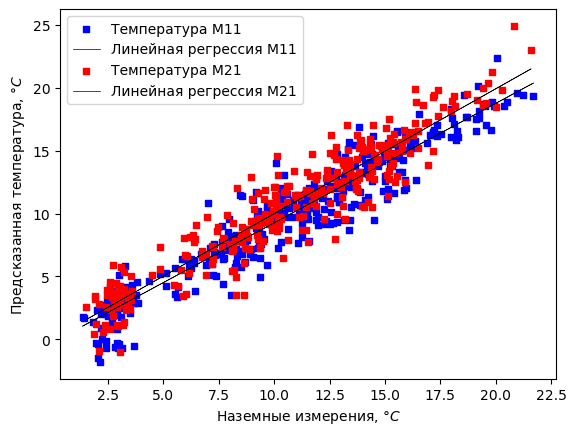

In [ ]:
blue_transparent = (0,0,1,0.5)
red_transparent = (1,0,0,0.5)
plot_validation_multiple([m11_full[0], m21_full[0]], [m11_full[1], m21_full[1]], [blue_transparent, red_transparent], ['b', 'r'], ["M11", "M21"])

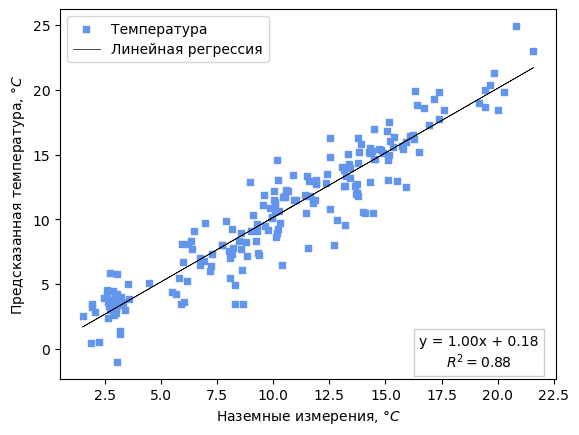

In [47]:
plot_validation(m21_day[0], m21_day[1])

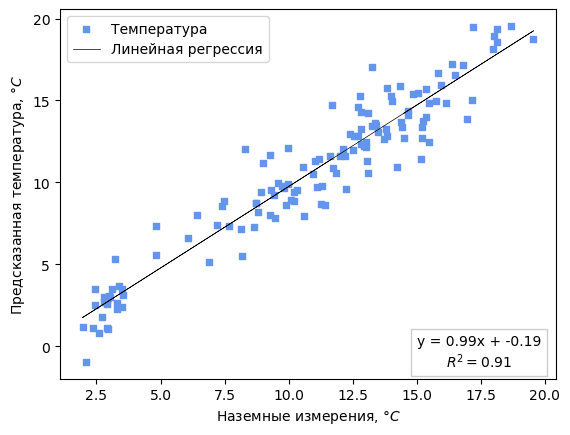

In [48]:
plot_validation(m21_night[0], m21_night[1])

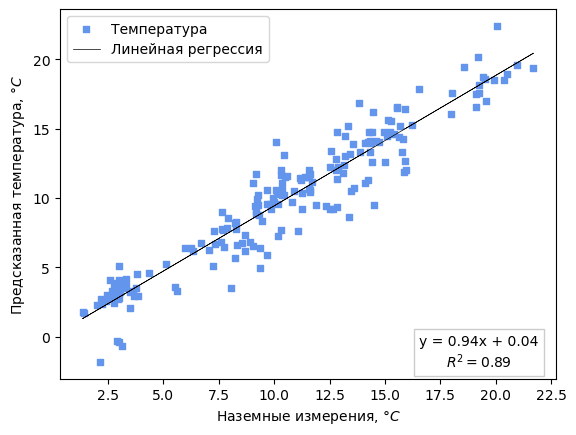

In [49]:
plot_validation(m11_day[0], m11_day[1])

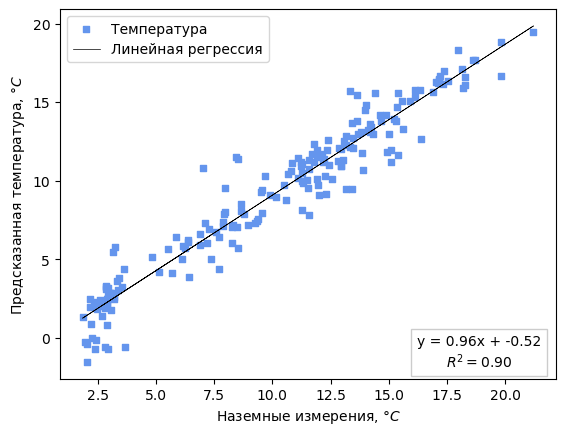

In [50]:
plot_validation(m11_night[0], m11_night[1])

In [ ]:
with open("Данные_валидации/Статистики/modis_aqua_terra_m11_m21.txt", "a") as at12, open("Данные_валидации/Статистики/modis_aqua_terra_m11.txt", "a") as at1, open("Данные_валидации/Статистики/modis_aqua_terra_m21.txt", "a") as at2, open("Данные_валидации/Статистики/modis_aqua_m11_m21.txt", "a") as a12, open("Данные_валидации/Статистики/modis_aqua_m11.txt", "a") as a1, open("Данные_валидации/Статистики/modis_aqua_m21.txt", "a") as a2, open("Данные_валидации/Статистики/modis_terra_m11_m21.txt", "a") as t12, open("Данные_валидации/Статистики/modis_terra_m11.txt", "a") as t1, open("Данные_валидации/Статистики/modis_terra_m21.txt", "a") as t2:
   for distance_limit_m in range(100, 2100, 100):
      
      # Aqua
      ## M11
      print(f"Distance from shore: {distance_limit_m} m\n", file=a1)

      print("Day+Night\n", file=a1)
      get_metrics_validation(result_in_situ_full_aqua_M11, result_image_full_aqua_M11, a1)

      print("Day\n", file=a1)
      get_metrics_validation(result_in_situ_day_aqua_M11, result_image_day_aqua_M11, a1)

      print("Night\n", file=a1)
      get_metrics_validation(result_in_situ_night_aqua_M11, result_image_night_aqua_M11, a1)
      ## M21
      print(f"Distance from shore: {distance_limit_m} m\n", file=a2)

      print("Day+Night\n", file=a2)
      get_metrics_validation(result_in_situ_full_aqua_M21, result_image_full_aqua_M21, a2)

      print("Day\n", file=a2)
      get_metrics_validation(result_in_situ_day_aqua_M21, result_image_day_aqua_M21, a2)

      print("Night\n", file=a2)
      get_metrics_validation(result_in_situ_night_aqua_M21, result_image_night_aqua_M21, a2)
      ## M11+M21
      print(f"Distance from shore: {distance_limit_m} m\n", file=a12)
      print("Day+Night\n", file=a12)
      get_metrics_validation(result_in_situ_full_aqua, result_image_full_aqua, a12)

      print("Day\n", file=a12)
      get_metrics_validation(result_in_situ_day_aqua, result_image_day_aqua, a12)

      print("Night\n", file=a12)
      get_metrics_validation(result_in_situ_night_aqua, result_image_night_aqua, a12)
      
      # Terra
      ## M11
      print(f"Distance from shore: {distance_limit_m} m\n", file=t1)

      print("Day+Night\n", file=t1)
      get_metrics_validation(result_in_situ_full_terra_M11, result_image_full_terra_M11, t1)

      print("Day\n", file=t1)
      get_metrics_validation(result_in_situ_day_terra_M11, result_image_day_terra_M11, t1)

      print("Night\n", file=t1)
      get_metrics_validation(result_in_situ_night_terra_M11, result_image_night_terra_M11, t1)
      ## M21
      print(f"Distance from shore: {distance_limit_m} m\n", file=t2)

      print("Day+Night\n", file=t2)
      get_metrics_validation(result_in_situ_full_terra_M21, result_image_full_terra_M21, t2)

      print("Day\n", file=t2)
      get_metrics_validation(result_in_situ_day_terra_M21, result_image_day_terra_M21, t2)

      print("Night\n", file=t2)
      get_metrics_validation(result_in_situ_night_terra_M21, result_image_night_terra_M21, t2)
      ## M11+M21
      print(f"Distance from shore: {distance_limit_m} m\n", file=t12)
      print("Day+Night\n", file=t12)
      get_metrics_validation(result_in_situ_full_terra, result_image_full_terra, t12)

      print("Day\n", file=t12)
      get_metrics_validation(result_in_situ_day_terra, result_image_day_terra, t12)

      print("Night\n", file=t12)
      get_metrics_validation(result_in_situ_night_terra, result_image_night_terra, t12)
      
      # Aqua + Terra
      ## M11
      print(f"Distance from shore: {distance_limit_m} m\n", file=at1)

      print("Day+Night\n", file=at1)
      get_metrics_validation(result_in_situ_full_M11, result_image_full_M11, at1)

      print("Day\n", file=at1)
      get_metrics_validation(result_in_situ_day_M11, result_image_day_M11, at1)

      print("Night\n", file=at1)
      get_metrics_validation(result_in_situ_night_M11, result_image_night_M11, at1)
      ## M21
      print(f"Distance from shore: {distance_limit_m} m\n", file=at2)

      print("Day+Night\n", file=at2)
      get_metrics_validation(result_in_situ_full_M21, result_image_full_M21, at2)

      print("Day\n", file=at2)
      get_metrics_validation(result_in_situ_day_M21, result_image_day_M21, at2)

      print("Night\n", file=at2)
      get_metrics_validation(result_in_situ_night_M21, result_image_night_M21, at2)
      ## M11+M21
      print(f"Distance from shore: {distance_limit_m} m\n", file=at12)
      print("Day+Night\n", file=at12)
      get_metrics_validation(result_in_situ_full, result_image_full, at12)

      print("Day\n", file=at12)
      get_metrics_validation(result_in_situ_day, result_image_day, at12)

      print("Night\n", file=at12)
      get_metrics_validation(result_in_situ_night, result_image_night, at12)

M11 занижает t, M21 завышает t